results are wrong

placing of random seed is crucial 

In [92]:
import numpy as np
import matplotlib.pyplot as plt

In [93]:
def source1(no_of_users)->np.ndarray:
    return np.random.uniform(-1, 1, (no_of_users))
    # return np.array([0.1, 0.1, 0.1, 0.1, 0.1])

Changed bi

In [94]:
plotting=0
comments=0

no_of_sources=5
no_of_slots=4
threshold_prob=0.9999
threshold_prob_range= np.linspace(0.1, 0.99,100)
snr=50
snr_range=np.arange(0,snr+1)
available_power=0.4
slots_range=np.arange(1,no_of_slots+1)

iterations=1000

In [95]:
def pre_process1(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float,power:float) -> np.ndarray:   
    # comments=1
    b = alpha/ cha_coeff # Standard preprocessing
    if(comments):
        # print("\t\tb=",b)
        # print("\t\th=",cha_coeff)
        print("\t\tbh=",b*cha_coeff)
        pass 
    return msg * b

def pre_process2(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float,power:float) -> np.ndarray:
    # comments=1
    b = alpha *(cha_coeff/(np.abs(cha_coeff)) ) *np.minimum(1/ (np.abs(cha_coeff)),np.sqrt(power)/alpha) # Standard preprocessing
    if(comments):
        # print("\t\tb=",b)
        # print("\t\th=",cha_coeff)
        print("\t\tbh=",b*cha_coeff)
        pass 
    return msg * b


instead of ∑x_i b_i h_i + n  changed to  ∑x_i b_i h_i + n_i

In [96]:
def awgn_mac_with_channel_coeff(symbols, snr_db,channel_coeff)->np.ndarray:
    
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    
    if(comments):
        print("\t\txb=",symbols)
        print("\t\th=",channel_coeff)
        print("\t\txbh=",faded_symbols,np.sum(faded_symbols))
        pass
    
    signal_power = np.mean(np.abs(symbols) ** 2)   # Signal power calculation
    snr_linear = 10**(snr_db / 10.0)
    noise_variance = signal_power / (snr_linear)
    noise =np.sqrt(noise_variance) * np.random.randn(*faded_symbols.shape)# Noise generation
    
    combined_faded_symbols =np.sum(faded_symbols) + np.sum(noise)
    # noise=0
    
    if(comments):
        print("\t\t∑xbh=",combined_faded_symbols)
        print("\t\tn=",noise)
        pass
    return combined_faded_symbols,noise_variance

changed bi

In [97]:
def demod1(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    b=alpha / cha_coeff
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

def demod2(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    b=alpha*(cha_coeff/(np.abs(cha_coeff)) ) *np.minimum(1/ (np.abs(cha_coeff)),np.sqrt(power)/alpha) # Standard preprocessing
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

input parmaeters

In [98]:
mse = []
for snr in snr_range: 
    rnd_seed=3
    np.random.seed(rnd_seed)
    alpha=np.sqrt( 2* np.log(  (1/ (1-(1-threshold_prob )**(1/no_of_slots))  )  ) )
    # alpha=1
    channel_threshold=alpha/ np.sqrt(available_power) 
    if(comments):   
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("parameter::",snr,"power",available_power,"channel threshold",channel_threshold)
        pass
    
    error=[]
    for j in range(iterations):
        
        # np.random.seed(np.random.randint(0,100000)) 
               
        source_main=source1(no_of_sources)
        if(comments):
            print(" iter ",j+1,100*"*")
            print("source:",source_main,source_main.sum())
            
        source=source_main.copy()
        recovered_appending=np.array([])
        for i in slots_range:
        #upto N-1 slots
            if(i<no_of_slots):
                channel_coeff=np.random.randn(len(source))
                if(comments):
                    print(f"\tslot {i}")
                    print(f"\t\th'={np.abs(channel_coeff)}")
                    pass
                eligible_msgs=source[np.abs(channel_coeff)>channel_threshold] 
                # if there are msgs to send
                if len(eligible_msgs) == 0:
                    continue
                
                if(plotting):
                    # Plot the main messages with labels
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(eligible_msgs)), eligible_msgs, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr} ,slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    plt.grid(True)
                    pass

                non_transmitted=source[np.abs(channel_coeff)<=channel_threshold]  
                
                channel_gains=channel_coeff[np.abs(channel_coeff)>channel_threshold]  
                
                if(comments):
                    print(f"\t\tx={eligible_msgs}")
                    pass              

                transmitted=pre_process1(eligible_msgs,channel_gains,alpha,available_power)

                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass

                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                if(plotting):
                    plt.plot( received, "h", markersize=10)
                    plt.ylim(-1,1)
                    pass   
                
                recovered_signal=demod1(received,channel_gains,available_power,alpha,noise_var)

                recovered_appending=np.append(recovered_appending,recovered_signal)
                
                if(comments):
                    print("\t\tr=",recovered_signal)
                    # print("\t\t---------------------------------------------")
                    pass
                source=non_transmitted



          
                #if some node haven't sent in prevous slots
            if i==no_of_slots:
                if len(source) == 0:
                    continue                
                if(comments):
                    print(f"\tslot {i}")
                    print(f"\t\tx={non_transmitted}")
                    pass
                
                channel_gains=np.random.randn(len(non_transmitted))

                if(plotting):
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(non_transmitted)), non_transmitted, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr},slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    # plt.legend()
                    plt.grid(True)
                    pass
                                
                transmitted=pre_process2(non_transmitted,channel_gains,alpha,available_power)
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, received, "h", markersize=10)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                recovered_signal=demod2(received,channel_gains,available_power,alpha,noise_var)
                recovered_appending=np.append(recovered_appending,recovered_signal)

                if(comments):
                    print("\t\tr=",recovered_signal)
                    print("\t\t---------------------------------------------")
                    pass
                
        # print("\t\t______________________________________________________________________")
        error.append(np.mean((source_main.sum() - recovered_appending.sum()) ** 2))
        if(comments):
            print("\t\t\tsource sum",source_main.sum())
            print("\t\t\trecovered",recovered_appending.sum())
            print("\t\t\terror",error)
            pass
    mse.append(np.mean(error))
    # print("mse",mse)

bh>0 always

In [99]:
print("\nSNR:",snr_range)
print("MSE:",mse)


SNR: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
MSE: [0.9991143420574492, 0.8603577626453177, 0.7379696492764468, 0.6312448815131121, 0.5390464786758489, 0.45998652590834177, 0.3925742337393296, 0.33532712884548704, 0.2868460842677215, 0.245858626496696, 0.21123735868145962, 0.18200112866279822, 0.1573058950309548, 0.13643070543095073, 0.11876248882619046, 0.10378187469404944, 0.09105104185157878, 0.08020362329839183, 0.07093602331600862, 0.0629992898531262, 0.056190951775847556, 0.05034675868689637, 0.045332711855433125, 0.041037924344173186, 0.037368711139541017, 0.03424405894152408, 0.03159241964392114, 0.029349658693092827, 0.027457932647847606, 0.025865229893419935, 0.02452528543980919, 0.02339759921903747, 0.02244735785383163, 0.021645163562826922, 0.02096657399011741, 0.020391521461450794, 0.01990369841551747, 0.019489977940980934, 0.01913990409344706, 0.01884525105

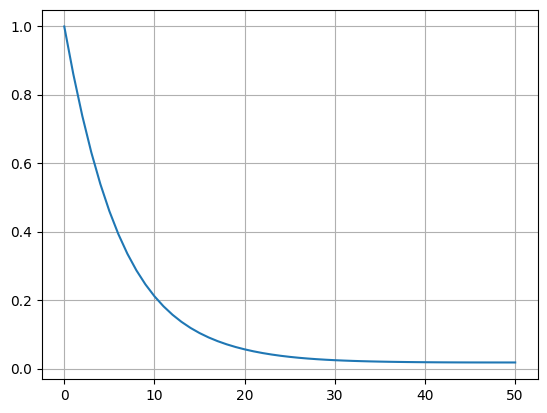

In [100]:
plt.plot(snr_range,mse)
plt.grid(True)
plt.show()